In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

In [2]:
import bloqade
from bloqade.ir.location import Chain, start

# Quantum Reservoir Computing Demo

In this notebook we will show you how to train a model to classify MNIST images using quantum reservoir computing (QRC) with Bloqade. The general idea is that the chaotic, non-linear dynamics of quantum systems can be used to create a non-linear mapping from a low-dimensional space (which will be PCA embeddings extracted from the MNIST images) to a high dimensional space. In order to construct the mapping, we first ensure that information from the image will totally specify the dynamics of the quantum system. Then, we measure certain properties (in this case, spin expectations and correlations) over time. These measurements form the output of the mapping.   

Through the embedding in this high dimensional space classification on using standard ML techniques is expected to perform better. 

This demo provides a toy model that does not require access to a quantum computer. It uses classical, numerical simulations of a quantum system with 8 qubits. The classical simulation makes use of the package Bloqade, which is designed for numerical simulations of neutral-atom architectures. With only a minimal of changes, we can use the same code to submit our jobs to Aquila hardware and analyse results.

Neutral atom architectures provide access to several variational parameters. In this demo, we map pixelated descriptions of the images to the local detuning terms in the Rydberg Hamiltonian. We then measure the quantum system and train the classical model which maps the quantum readout from the measurement to the desired prediction. As all training process is in the classical part (excuted on a classical computer), we expect the training is substantially shorter than other traditional quantum machine learning models. More details on numerical simulation of neutral-atom architectures, and the range of the parameters can be found from [Bloqade](https://github.com/QuEraComputing/bloqade-python) documentation. 

In [3]:
# Download the MNIST dataset and rescaling data
                     
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X, test_X = train_X / 255.0, test_X / 255.0

## training data set (each image has 28x28 pixels and there are 60000 training samples)
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))

## test data set (10000 test samples)
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


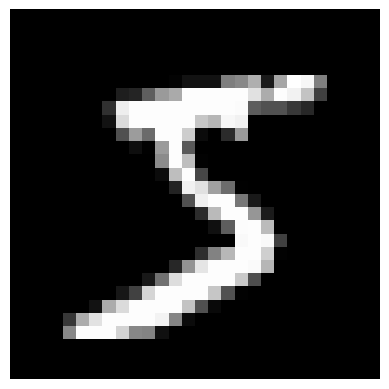

In [4]:
# example of an training dataset image for '5'
plt.imshow(train_X[0], cmap=plt.get_cmap('gray'), interpolation='None')
plt.axis('off')
plt.show()


## PCA Reduction

In this notebook, we first train a toy model using 1000 samples from the MNIST dataset.

The images form the input into the quantum system. As we focus on numerical simulation where the number of atoms in the quantum system is limited, we first perform dimensionality reduction using the [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). 

In [5]:
# We first use PCA to downsample the data into 10-dimensional vectors
dim_pca = 8

# Use the `fit` function from the `sklearn` package to define the PCA model and apply to training set
pca=PCA(n_components=dim_pca).fit(np.reshape(train_X, (60000,28*28)))
x=pca.transform(np.reshape(train_X, (60000,28*28)))

# Let us see how it looks
num_examples = 1000
xs = x[:num_examples,:]
print("Training set PCA: \n ", xs[0:5,:], "\n")

#processing the test set
xt=pca.transform(np.reshape(test_X, (10000,28*28)))

# Let us see how it looks
num_test_examples = 200
xs_test = xt[:num_test_examples,:]
print("Test set PCA: \n ", xs[0:5,:], "")

Training set PCA: 
  [[ 0.48601015  1.22617358  0.09613354  2.17944297 -0.10704576  0.9116717
   0.91763033  0.62666468]
 [ 3.96752304  1.15630211 -2.33858651  1.80692626 -3.24421656  0.71353148
  -0.17655089 -0.41164546]
 [-0.2033318  -1.53793393  0.73925392 -2.04318175 -1.20266952  0.00719743
  -3.36881255  1.44545833]
 [-3.13383152  2.38116556 -1.07314212 -0.41520877 -0.00726755 -2.74374391
  -1.85769884 -0.2640067 ]
 [-1.50099977 -2.86487399 -0.06413234  0.94783341  0.38494646 -0.16952834
  -0.35947686 -1.59041131]] 

Test set PCA: 
  [[ 0.48601015  1.22617358  0.09613354  2.17944297 -0.10704576  0.9116717
   0.91763033  0.62666468]
 [ 3.96752304  1.15630211 -2.33858651  1.80692626 -3.24421656  0.71353148
  -0.17655089 -0.41164546]
 [-0.2033318  -1.53793393  0.73925392 -2.04318175 -1.20266952  0.00719743
  -3.36881255  1.44545833]
 [-3.13383152  2.38116556 -1.07314212 -0.41520877 -0.00726755 -2.74374391
  -1.85769884 -0.2640067 ]
 [-1.50099977 -2.86487399 -0.06413234  0.94783341  0

Here, we scale the range of principal components to a feasible range for local detuning implementation, [0, 1]. And later, for each image, we will encode each of the 8 scaled principal components into each single local detuning for 8 atoms. For more details of the neutral atom quantum system, please refer to the documentation of [Bloqade](https://queracomputing.github.io/Bloqade.jl/dev/#What-does-Bloqade-Do?).

In [6]:
spectral =(np.amax(xs) - np.amin(xs))
m1=np.amin(xs)
xs = (xs - m1)/spectral # to make sure values to be between [0, 1]
xs_test = (xs_test - m1)/spectral # the same transformation on the test set

## Build quantum tasks and simulate dynamics

We can now set up the quantum simulation. 

- Define a `dictionary`, which captures all physical parameters and readouts of the quantum system.
- Define functions that simulate quantum dynamics or build tasks that can me submitted to hardware with the input `x` from scaled detunings 
- The simulation of the quantum dynamics has been implemented in [Bloqade](https://github.com/QuEraComputing/bloqade-python)

In [7]:
QRC_parameters={
    "atom_number":dim_pca, #number of atoms, equal to the dimension of PCA feature vector
    "geometry_spec":Chain(dim_pca, lattice_spacing=10), #atom geometry - we will use a linear chain with 10 micron distance between atoms
    "encoding_scale":9.0, #scaling factor for local detuning encoding
    "rabi_frequency":6.283,#value of Rabi frequency used
    "total_time":4, #total maximum evolution time - 4 microseconds
    "time_steps":8, #number of probe times for quantum embedding collection - 8 in the 4 microsecond window
    "readouts":"ZZ", #includes both ZZ correlators together with default Rydberg density as generated embeddings
}

Here, we define the function that will proccess the QRC parameters define above and return a task that can be either simulated or ran on hardware. In addition, we define the processing pipeline that will turn the samples collected on hardware or in simulation into QRC embeddings.

In [8]:
#Main function for building quantum tasks.
def build_task(QRC_parameters, xs1):
    natoms=QRC_parameters["atom_number"]
    encoding_scale=QRC_parameters["encoding_scale"]
    dt=QRC_parameters["total_time"]/QRC_parameters["time_steps"]
    #builds global Rabi and detuning pulses
    rabi_oscillations_program = (QRC_parameters["geometry_spec"]
            .rydberg.rabi.amplitude.uniform.constant(
                duration="run_time", value=QRC_parameters["rabi_frequency"]
            )
            .detuning.uniform.constant(duration="run_time", value=encoding_scale/2)
            #adds local detuning according to the feature vector
            .scale(list(xs1)).constant(duration="run_time", value=-encoding_scale)
            ) 
    rabi_oscillation_job = rabi_oscillations_program.batch_assign(run_time=np.arange(1, QRC_parameters["time_steps"]+1, 1)*dt)
    #`batch_assign` used to probe the quantum reservoir at set number of timesteps
    return rabi_oscillation_job

#To obtain the embeddings, we process the report containing the collected samples into embeddins made of Z and ZZ observables.
def process_results(QRC_parameters, report):  
    embedding=[]
    natoms=QRC_parameters["atom_number"]
    try:
        for t in range(QRC_parameters["time_steps"]):
            ar1=-1.0+2*((report.bitstrings())[t])
            nsh1=ar1.shape[0]
            for i in range(natoms):
                embedding.append(np.sum(ar1[:,i])/nsh1) #Z expectation values
            if QRC_parameters["readouts"]=="ZZ":
                for i in range(natoms):
                    for j in range(i+1,natoms):
                        embedding.append(np.sum(ar1[:,i]*ar1[:,j])/nsh1) #ZZ expectation values
    except: #In case no experimental results were obtained.
        print("No results exist.")
        for t in range(QRC_parameters["time_steps"]):
            for i in range(natoms):
                embedding.append(0.0)
            if QRC_parameters["readouts"]=="ZZ":
                for i in range(natoms):
                    for j in range(i+1,natoms):
                        embedding.append(0.0)
    return embedding

#Processing if only samples are needed.
def process_results_samples(QRC_parameters, report):  
    embedding=[]
    natoms=QRC_parameters["atom_number"]
    try:
        embedding=report.bitstrings()
        # for t in range(QRC_parameters["time_steps"]):
        #     ar1=-1.0+2*((report.bitstrings())[t])
        #     nsh1=ar1.shape[0]
        #     for i in range(natoms):
        #         embedding.append(np.sum(ar1[:,i])/nsh1) #Z expectation values
        #     if QRC_parameters["readouts"]=="ZZ":
        #         for i in range(natoms):
        #             for j in range(i+1,natoms):
        #                 embedding.append(np.sum(ar1[:,i]*ar1[:,j])/nsh1) #ZZ expectation values
    except: #In case no experimental results were obtained.
        print("No results exist.")
        for t in range(QRC_parameters["time_steps"]):
            for i in range(natoms):
                embedding.append(0.0)
            if QRC_parameters["readouts"]=="ZZ":
                for i in range(natoms):
                    for j in range(i+1,natoms):
                        embedding.append(0.0)
    return embedding

In order to generate QRC embeddings, we will call emulation routines for the tasks we build and process the resulting data. We will collect 1000 samples per datapoint in emulation

In [9]:
##Simulating and gathering samples only
# samples_train=np.array([process_results_samples(QRC_parameters, 
#         build_task(QRC_parameters, xs[data,:]).bloqade.python().run(shots=100, rtol=1e-8, atol=1e-8).report())
#         for data in range(num_examples)])
# np.save("samples_train.npy", samples_train)
# samples_test=np.array([process_results_samples(QRC_parameters, 
#         build_task(QRC_parameters, xs_test[data,:]).bloqade.python().run(shots=100, rtol=1e-8, atol=1e-8).report())
#         for data in range(num_test_examples)])
# np.save("samples_test.npy", samples_test)

In [10]:
def get_embeddings_emulation(xs, num_examples, nshots=1000):
    return np.array([process_results(QRC_parameters, 
        build_task(QRC_parameters, xs[data,:]).bloqade.python().run(shots=nshots, rtol=1e-8, atol=1e-8).report())
        for data in range(num_examples)])

Now, we are ready to run the simulation by apply the defined emulation pipeline to the scaled feature vectors! For each image, the readouts from the quantum dynamics is a 288-dimensional vector which has much higher dimension than the PCA dimension. The full results will be stored in a $1000\times 288$ matrix `embeddings`.

(It might take a few minutes)

In [11]:
embeddings=get_embeddings_emulation(xs, num_examples, nshots=1000)
test_embeddings=get_embeddings_emulation(xs_test, num_test_examples, nshots=1000)

In [12]:
print(embeddings.shape)
print(test_embeddings.shape)

(1000, 288)
(200, 288)


## Training Neural Network and Evaluating Performance

Now we are going to train a classical neural network without hidden layers (a linear classifier with `softmax` output function), using quantum measurements stored in `embeddings` as the input. In comparision, we also trained a neural network without hidden layers directly using PCA feature vectors without the quantum reservoir processing, as well as a simple neural network with two hidden layers for comparison.

Here, we used the machine learning framework of [tensorflow](https://www.tensorflow.org/) for the neural network training.

First, let's see the results of a linear classifier applied on PCA features directly.

In [13]:
#building a linear model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10)
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#fitting to train data
model.fit(xs, train_y[:num_examples], epochs=1000, batch_size=100, verbose=0)

#evaluating on test data
test_loss, test_acc = model.evaluate(xs_test,  test_y[:num_test_examples], verbose=0)
print('PCA test accuracy:', 100*round(test_acc, 2), "%")


PCA test accuracy: 69.0 %


And now, let's apply the same linear classifier on our QRC embeddings.

In [14]:
#building a linear model
#we include regularization and tune epsilon parameter of the optimizer to better control training from QRC embeddings generated on finite number of samples
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.L1(l1=0.0001))
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.0002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#fitting to train data
model.fit(embeddings, train_y[:num_examples], epochs=2000, batch_size=100, verbose=0)

#evaluating on test data
test_loss, test_acc = model.evaluate(test_embeddings,  test_y[:num_test_examples], verbose=0)
print('QRC test accuracy:', 100*round(test_acc, 2), "%")


QRC test accuracy: 83.0 %


QRC embeddings significantly outperform linear classifier on PCA embeddings only!

Finally, let's compare with a sizable classical neural network with two hidden layers.

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10),

    ])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(xs, train_y[:num_examples], epochs=1000, batch_size=100, verbose=0)
test_loss, test_acc = model.evaluate(xs_test,  test_y[:num_test_examples], verbose=0)
print('4-layer NN test accuracy:', 100*round(test_acc, 2), "%")

4-layer NN test accuracy: 81.0 %


While in this case classical neural network outperforms QRC, this is a consequence of limited dataset size. With more data, QRC will match the 4-layer neural network performance.

In [15]:
#The same implemented with LinearSVC and SVC from sklearn.

svm = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm.fit(xs, train_y[:num_examples])
y_pred = svm.predict(xs_test)
accuracy=svm.score(xs_test, test_y[:num_test_examples])
print('Linear SVM test accuracy:', 100*round(accuracy, 2), "%")

svm = SVC(C=8.)
svm.fit(xs, train_y[:num_examples])
y_pred = svm.predict(xs_test)
accuracy=svm.score(xs_test, test_y[:num_test_examples])
print('SVC test accuracy (rbf kernel):', 100*round(accuracy, 2), "%")


svm = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm.fit(embeddings, train_y[:num_examples])
y_pred = svm.predict(embeddings)
accuracy=svm.score(test_embeddings, test_y[:num_test_examples])
print('QRC test accuracy:', 100*round(accuracy, 2), "%")


c:\Users\mkornjaca\anaconda3\envs\blpy_June\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM test accuracy: 70.0 %
SVC test accuracy (rbf kernel): 89.0 %
QRC test accuracy: 84.0 %


## Implementation on Aquila

The convenience of [Bloqade](https://github.com/QuEraComputing/bloqade-python) allows us to submit the same tasks to Aquila with only minimal changes and test our algorithm! Let's start by gathering AWS braket credentials.

In [19]:
#AWS braket credentials
os.environ["AWS_ACCESS_KEY_ID"] = "key1"
os.environ["AWS_SECRET_ACCESS_KEY"] = "key2"
os.environ["AWS_SESSION_TOKEN"] = "key3"

We are now ready to submit the tasks that we emulated. The only difference from emulation is that we're going to save are tasks as we'll have to wait for their turn in the Aquila queue. 

In addition, for basic tests, we will lower the number of shots that we gather for each image. While the performance will neccesarily be lower than in emulation,  this will allow us to obtain results faster for the proof of principle showcase. Furthermore, we will use the built-in `parallelize` Bloqade capability, that we'll allow us to paralelize our sampling by running several instances of our atom chain in parallel on Aquila.

In [21]:
path_to_tasks="./qrc_tasks"
if not os.path.exists(path_to_tasks):
  os.mkdir(path_to_tasks)
  

#Train task submissions
nshots=10 #The actual number of shots collected per image will be 60, as we parallelize our sampling with 6 chains that are 15 micrometers appart.
for data in range(num_examples):
    try:
        #task=build_task(QRC_parameters, xs[data,:]).parallelize(15).braket.aquila().run_async(shots=nshots, name = "QRC_train_"+str(data))
        task=build_task(QRC_parameters, xs[data,:]).parallelize(15).quera.mock().run_async(shots=nshots, name = "QRC_train_"+str(data))
        bloqade.save(
            task,
            path_to_tasks + "/" + "qrc_train_" + str(data) + ".json",       
        )
    except:
       print("Training task " + str(data) + " was not submitted.")



#Test task submissions
for data in range(num_test_examples):
    try:
        #task=build_task(QRC_parameters, xs[data,:]).parallelize(15).braket.aquila().run_async(shots=nshots, name = "QRC_test_"+str(data))
        task=build_task(QRC_parameters, xs_test[data,:]).parallelize(15).quera.mock().run_async(shots=nshots, name = "QRC_test_"+str(data))
        bloqade.save(
            task,
            path_to_tasks + "/" + "qrc_test_" + str(data) + ".json",       
        )
    except:
       print("Test task " + str(data) + " was not submitted.")



Once the tasks have been completed, we gather Aquila results and save them.

In [ ]:
path_to_results="./qrc_results"
if not os.path.exists(path_to_results):
  os.mkdir(path_to_results)


#Train task fetching
for data in range(num_examples):
    try:
        task = bloqade.load(path_to_tasks + "/" + "qrc_train_" + str(data) + ".json")
        bloqade.save(
            task.fetch(),
            path_to_results + "/" + "qrc_train_" + str(data) + ".json",       
        )
    except:
        print("Training task " + str(data) + " was not saved.")

#Test task fetching
for data in range(num_test_examples):
    try:
        task = bloqade.load(path_to_tasks + "/" + "qrc_test_" + str(data) + ".json")
        bloqade.save(
            task.fetch(),
            path_to_results + "/" + "qrc_test_" + str(data) + ".json",       
        )
    except:
        print("Test task " + str(data) + " was not saved.")

Just like that, everything is in place for generating QRC embeddings from hardware. We can even use the same processing pipeline as for emulator results.

In [ ]:
embeddings_Aquila=[]
for data in range(num_examples):
    task_report = bloqade.load(path_to_results + "/" + "qrc_train_" + str(data) + ".json").report()
    embeddings.append(process_results(QRC_parameters,task_report))
embeddings_Aquila=np.array(embeddings_Aquila)

test_embeddings_Aquila=[]
for data in range(num_test_examples):
    task_report = bloqade.load(path_to_results + "/" + "qrc_train_" + str(data) + ".json").report()
    test_embeddings_Aquila.append(process_results(QRC_parameters,task_report))
test_embeddings_Aquila=np.array(test_embeddings_Aquila)


Finally, let's train our linear classification layer on Aquila embeddings!

In [ ]:
#building a linear model
#we include regularization and tune epsilon parameter of the optimizer to better control training from QRC embeddings generated on finite number of samples
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.L1(l1=0.02))
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.0002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#fitting to train data
model.fit(embeddings_Aquila, train_y[:num_examples], epochs=1500, batch_size=100, verbose=0)

#evaluating on test data
test_loss, test_acc = model.evaluate(test_embeddings_Aquila,  test_y[:num_test_examples], verbose=0)
print('QRC test accuracy on Aquila:', 100*round(test_acc, 2), "%")

Aquila has succesfully performed MNIST classification! Note, due to the limited sampling for this proof of principle experiment, the performance is significantly below the emulated performance.